In [1]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Reshape, Embedding, Concatenate
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer  # Import Layer directly from tensorflow.keras.layers

class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(1, 1, input_shape[-1]), dtype="float32"),
            trainable=True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)

        return cls
def mlp(x,cf):
    x = Dense(cf["mlp_dim"],activation = "gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x


def transformer_encoder(x,cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads = cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x,x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x=mlp(x,cf)
    x = Add()([x, skip_2])

    return x

def ResNet50ViT(cf):
    """ Input """
    inputs = Input((cf["image_size"], cf["image_size"], cf["num_channels"])) ## (None, 512, 512, 3)

    """ Pre-trained Resnet50 """
    efficientnet = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)  # Updated instantiation
    output = efficientnet.output ## (None, 16, 16, 2048)

    """ Patch Embeddings """
    patch_embed = Conv2D(
        cf["hidden_dim"],
        kernel_size=cf["patch_size"],
        padding="same"
    )(output) ## (None, 16, 16, 768)
    _, h, w, f = patch_embed.shape
    patch_embed = Reshape((h * w, f))(patch_embed) #((None, 64, 768)
    """ Position Embedding"""
    position = tf.range(start=0, limit=min(cf["num_patches"], h*w), delta=1) # Limit num_patches to match the available space
    pos_embed = Embedding(input_dim=min(cf["num_patches"], h*w), output_dim=cf["hidden_dim"])(position) #(min(h*w, num_patches), 768)

    """ Patch + Position Embeddings """
    embed = patch_embed + pos_embed
    print(embed.shape)

    """Adding Class Token """
    token = ClassToken()(embed)
    x= Concatenate(axis=1)([token,embed])
    print(x.shape)

    """ transformer encoder"""

    for _ in range(cf["num_layers"]):
        x=transformer_encoder(x,cf)

    x = LayerNormalization()(x)
    x = x[:, 0, :]
    x = Dense(cf["num_classes"], activation="softmax")(x)

    model = Model(inputs, x)
    return model


2024-05-01 12:27:26.827482: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 12:27:26.862171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 12:27:26.862199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 12:27:26.863012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 12:27:26.868200: I tensorflow/core/platform/cpu_feature_guar

In [2]:
if __name__ == "__main__":
    config = {}
    config["num_layers"] = 12
    config["hidden_dim"] = 768
    config["mlp_dim"] = 2048
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1

    config["image_size"] = 128
    config["patch_size"] = 4
    config["num_patches"] = 1024
    config["num_channels"] = 3
    config["num_classes"] = 4

    model = ResNet50ViT(config)
    model.summary()

2024-05-01 12:27:28.188483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14244 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


(None, 16, 768)
(None, 17, 768)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ rescaling           │ (None, 128, 128,  │       0 │ input_layer[0][0]    │
│ (Rescaling)         │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ normalization       │ (None, 128, 128,  │       7 │ rescaling[0][0]      │
│ (Normalization)     │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ rescaling_1         │ (None, 128, 128,  │       0 │ normalization[0][0]  │
│ (Rescaling)         │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │       0 │ rescaling_1[0][0]    │
│ (ZeroPadding2D)     │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │     864 │ stem_conv_pad[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stem_bn             │ (None, 64, 64,    │     128 │ stem_conv[0][0]      │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stem_activation     │ (None, 64, 64,    │       0 │ stem_bn[0][0]        │
│ (Activation)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │     288 │ stem_activation[0][… │
│ (DepthwiseConv2D)   │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_bn          │ (None, 64, 64,    │     128 │ block1a_dwconv[0][0] │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_activation  │ (None, 64, 64,    │       0 │ block1a_bn[0][0]     │
│ (Activation)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │       0 │ block1a_activation[… │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │       0 │ block1a_se_squeeze[… │
│ (Reshape)           │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │     264 │ block1a_se_reshape[… │
│ (Conv2D)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │     288 │ block1a_se_reduce[0… │
│ (Conv2D)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │       0 │ block1a_activation[… │
│ (Multiply)          │ 32)               │         │ block1a_se_expand[0… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │     512 │ block1a_se_excite[0

 Total params: 397,682,599 (1.48 GB)

 Trainable params: 397,640,576 (1.48 GB)

 Non-trainable params: 42,023 (164.16 KB)

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mping
import os
import shutil

In [4]:
root_path = r"/home/srikanth/Dataset/RGB_images"
dataset_path = os.listdir(root_path)

In [5]:
class_labels = []
count=0
for item in dataset_path:
    all_classes = os.listdir(root_path + '/' +item)
    for room in all_classes:
        photo = os.listdir(root_path + '/' +item + '/' +room)
        for image in photo:
            objects = os.listdir(root_path + '/' +item + '/' +room + '/' +image)
            for object in objects:
                class_labels.append((item,str(root_path + '/' +item + '/' +room + '/' +image +'/' +object)))
df = pd.DataFrame(data=class_labels, columns=['labels', 'image'])
y=list(df['labels'].values)
image=df['image']

In [6]:
df

,labels,image
0,Palmar wrist pronated,/home/srikanth/Dataset/RGB_images/Palmar wrist...
1,Palmar wrist pronated,/home/srikanth/Dataset/RGB_images/Palmar wrist...
2,Palmar wrist pronated,/home/srikanth/Dataset/RGB_images/Palmar wrist...
3,Palmar wrist pronated,/home/srikanth/Dataset/RGB_images/Palmar wrist...
4,Palmar wrist pronated,/home/srikanth/Dataset/RGB_images/Palmar wrist...
...,...,...
202032,Palmar wrist neutral,/home/srikanth/Dataset/RGB_images/Palmar wrist...
202033,Palmar wrist neutral,/home/srikanth/Dataset/RGB_images/Palmar wrist...
202034,Palmar wrist neutral,/home/srikanth/Dataset/RGB_images/Palmar wrist...
202035,Palmar wrist neutral,/home/srikanth/Dataset/RGB_images/Palmar wrist...


In [7]:
import cv2
import numpy as np
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


In [8]:
y=list(y)
image=df['image']
images, y= shuffle(image,y, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(images, y, test_size=0.2, random_state=415)
test_x = test_x.reset_index(drop=True)
train_x = train_x.reset_index(drop=True)
test_x, val_x, test_y, val_y = train_test_split(test_x,test_y, test_size=0.5, random_state=415)
test_x = test_x.reset_index(drop=True)
#train_y=list(train_y)
train_df=pd.DataFrame({'filepaths':train_x,'labels':train_y})
valid_df=pd.DataFrame({'filepaths':val_x,'labels':val_y})
test_df=pd.DataFrame({'filepaths':test_x,'labels':test_y})

In [9]:
print("Training set size:", len(train_x))

Training set size: 161629


In [10]:
train_df=pd.DataFrame({'filepaths':train_x,'labels':train_y})
print(df.head())
print(df.tail())

                  labels                                              image
0  Palmar wrist pronated  /home/srikanth/Dataset/RGB_images/Palmar wrist...
1  Palmar wrist pronated  /home/srikanth/Dataset/RGB_images/Palmar wrist...
2  Palmar wrist pronated  /home/srikanth/Dataset/RGB_images/Palmar wrist...
3  Palmar wrist pronated  /home/srikanth/Dataset/RGB_images/Palmar wrist...
4  Palmar wrist pronated  /home/srikanth/Dataset/RGB_images/Palmar wrist...
                      labels  \
202032  Palmar wrist neutral   
202033  Palmar wrist neutral   
202034  Palmar wrist neutral   
202035  Palmar wrist neutral   
202036  Palmar wrist neutral   

                                                    image  
202032  /home/srikanth/Dataset/RGB_images/Palmar wrist...  
202033  /home/srikanth/Dataset/RGB_images/Palmar wrist...  
202034  /home/srikanth/Dataset/RGB_images/Palmar wrist...  
202035  /home/srikanth/Dataset/RGB_images/Palmar wrist...  
202036  /home/srikanth/Dataset/RGB_images/Palmar wr

In [11]:
print(train_df['labels'].value_counts())

labels
Tripod                   56744
Palmar wrist pronated    50363
Pinch                    30683
Palmar wrist neutral     23839
Name: count, dtype: int64


In [12]:
valid_df=pd.DataFrame({'filepaths':val_x,'labels':val_y})
print(df.head())
print(df.tail())

                  labels                                              image
0  Palmar wrist pronated  /home/srikanth/Dataset/RGB_images/Palmar wrist...
1  Palmar wrist pronated  /home/srikanth/Dataset/RGB_images/Palmar wrist...
2  Palmar wrist pronated  /home/srikanth/Dataset/RGB_images/Palmar wrist...
3  Palmar wrist pronated  /home/srikanth/Dataset/RGB_images/Palmar wrist...
4  Palmar wrist pronated  /home/srikanth/Dataset/RGB_images/Palmar wrist...
                      labels  \
202032  Palmar wrist neutral   
202033  Palmar wrist neutral   
202034  Palmar wrist neutral   
202035  Palmar wrist neutral   
202036  Palmar wrist neutral   

                                                    image  
202032  /home/srikanth/Dataset/RGB_images/Palmar wrist...  
202033  /home/srikanth/Dataset/RGB_images/Palmar wrist...  
202034  /home/srikanth/Dataset/RGB_images/Palmar wrist...  
202035  /home/srikanth/Dataset/RGB_images/Palmar wrist...  
202036  /home/srikanth/Dataset/RGB_images/Palmar wr

In [13]:
test_df=pd.DataFrame({'filepaths':test_x,'labels':test_y})
print(test_df.head())
print(test_df.tail())

                                           filepaths                 labels
0  /home/srikanth/Dataset/RGB_images/Pinch/food_b...                  Pinch
1  /home/srikanth/Dataset/RGB_images/Palmar wrist...  Palmar wrist pronated
2  /home/srikanth/Dataset/RGB_images/Palmar wrist...  Palmar wrist pronated
3  /home/srikanth/Dataset/RGB_images/Pinch/shampo...                  Pinch
4  /home/srikanth/Dataset/RGB_images/Palmar wrist...  Palmar wrist pronated
                                               filepaths                labels
20199  /home/srikanth/Dataset/RGB_images/Pinch/toothb...                 Pinch
20200  /home/srikanth/Dataset/RGB_images/Pinch/shampo...                 Pinch
20201  /home/srikanth/Dataset/RGB_images/Tripod/pear/...                Tripod
20202  /home/srikanth/Dataset/RGB_images/Tripod/noteb...                Tripod
20203  /home/srikanth/Dataset/RGB_images/Palmar wrist...  Palmar wrist neutral


In [14]:
print(test_df['labels'].value_counts())

labels
Tripod                   7005
Palmar wrist pronated    6356
Pinch                    3886
Palmar wrist neutral     2957
Name: count, dtype: int64


In [15]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    sample_list=[]
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        sample_count=len(group)
        if sample_count> max_size :
            samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    balance=list(df[column].value_counts())
    print (balance)
    return df

In [16]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path)
    # create and store the augmented images
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='png')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    ndf=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
    print (list(ndf['labels'].value_counts()) )
    return ndf

In [17]:
max_samples= 60000
min_samples=0
column='labels'
working_dir = r'./'
img_size=(128,128)
ndf=balance(train_df,max_samples, min_samples, column, working_dir, img_size)

[56744, 50363, 30683, 23839]
Found 30683 validated image filenames.
Found 50363 validated image filenames.
Found 56744 validated image filenames.
Found 23839 validated image filenames.
[60000, 60000, 60000, 60000]


In [18]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 5, min_delta = 0.0001)

In [19]:
channels=3
batch_size=32
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=32
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( ndf, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))

test batch size:  32   test steps:  631
Found 240000 validated image filenames belonging to 4 classes.
Found 20204 validated image filenames belonging to 4 classes.
Found 20204 validated image filenames belonging to 4 classes.


In [20]:
len(test_df)

20204

In [21]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0007,momentum=0.9),
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

In [22]:
history = model.fit(train_gen , validation_data = valid_gen , epochs = 40)

Epoch 1/40


/home/srikanth/tens-env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-01 12:36:26.301849: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdff40222f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-01 12:36:26.301871: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2024-05-01 12:36:27.310012: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-01 12:36:34.361169: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] L

7500/7500 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9360 - loss: 0.1760

W0000 00:00:1714549237.590338    9720 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7500/7500 ━━━━━━━━━━━━━━━━━━━━ 2123s 270ms/step - accuracy: 0.9360 - loss: 0.1760 - val_accuracy: 0.9910 - val_loss: 0.0243
Epoch 2/40


W0000 00:00:1714549287.400294    9720 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7500/7500 ━━━━━━━━━━━━━━━━━━━━ 1958s 261ms/step - accuracy: 0.9897 - loss: 0.0231 - val_accuracy: 0.9915 - val_loss: 0.0124
Epoch 3/40
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 1951s 260ms/step - accuracy: 0.9913 - loss: 0.0179 - val_accuracy: 0.9922 - val_loss: 0.0119
Epoch 4/40
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 2088s 278ms/step - accuracy: 0.9923 - loss: 0.0154 - val_accuracy: 0.9913 - val_loss: 0.0115
Epoch 5/40
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 2069s 276ms/step - accuracy: 0.9926 - loss: 0.0148 - val_accuracy: 0.9910 - val_loss: 0.0115
Epoch 6/40
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 2058s 274ms/step - accuracy: 0.9928 - loss: 0.0136 - val_accuracy: 0.9914 - val_loss: 0.0114
Epoch 7/40
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 1973s 263ms/step - accuracy: 0.9928 - loss: 0.0135 - val_accuracy: 0.9917 - val_loss: 0.0128
Epoch 8/40
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 1962s 262ms/step - accuracy: 0.9929 - loss: 0.0130 - val_accuracy: 0.9913 - val_loss: 0.0115
Epoch 9/40
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 1962s 262ms/step - accur

In [23]:
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100

631/631 ━━━━━━━━━━━━━━━━━━━━ 46s 72ms/step - accuracy: 0.9911 - loss: 0.0116


In [24]:
acc

99.1184651851654

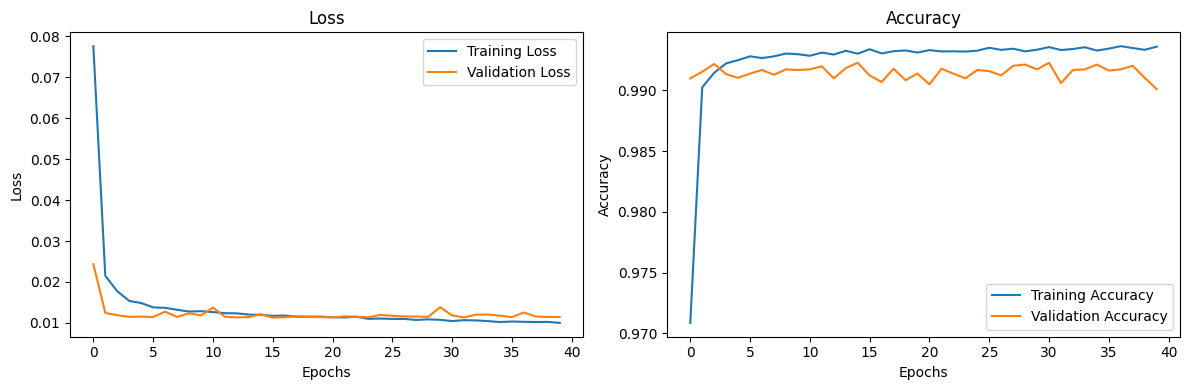

In [28]:
# PLOTTING
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
#Accuracy with whole graph

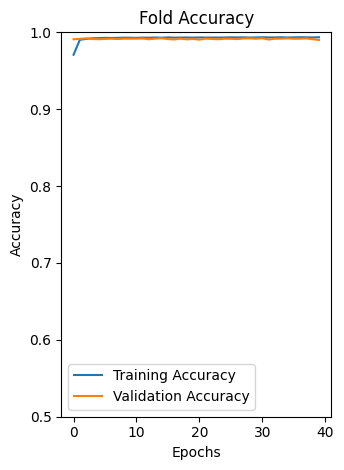

In [30]:
# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fold Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)  # Set y-axis limits from 0 to 100
plt.legend()

plt.tight_layout()
plt.show()